# Glacier bed inversion in OGGM

So far, we have only looked at the glacier surface: first by defining the surface geometry of our flowline, and then by defining and calibrating the surface mass balance. In this session, we will focus on how to define the glacier bed, which is necessary for running a dynamic simulation in the next session. However, since there are no direct observations available on a global scale, defining the glacier bed is a challenging task that requires some assumptions.

Let’s dive in!

## OGGM setup

First, we set up OGGM as usual. We still need to start from the level 2 preprocessed directories, as we are not yet at level 3. However, I will redo some tasks from previous sessions to bring the glacier directory to the stage we need for today’s work.

In [1]:
# first we import the packages we need for this session
from oggm import cfg, utils, workflow, tasks, graphics 
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
cfg.initialize()

# define working directory
path = 'inversion_working_dir'
utils.mkdir(path, reset=False)  # if you set reset=True, everything will be deleted and you can start from a fresh state
cfg.PATHS['working_dir'] = path

2025-04-28 09:25:07: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-04-28 09:25:07: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-04-28 09:25:07: oggm.cfg: Multiprocessing: using all available processors (N=8)


In [3]:
# select the glacier of your choice, you can use the Glims viewer from the first session
rgi_ids = ['RGI60-11.00897']  # Hintereisferner

# we load the outline data from the oggm cluster
prepro_base_url_L2 = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L1-L2_files/elev_bands/'
gdirs = workflow.init_glacier_directories(rgi_ids,
                                          from_prepro_level=2,  # here we select level 2
                                          prepro_base_url=prepro_base_url_L2,
                                          prepro_border=80,  # could be 10, 80, 160 or 240
                                         )
gdir = gdirs[0]  # for convenience, we define a single variable for our glacier

# redo some tasks of previous sessions to get everything we need for the inversion
workflow.execute_entity_task(tasks.compute_downstream_bedshape, gdirs);
workflow.execute_entity_task(tasks.process_climate_data, gdirs);
workflow.execute_entity_task(tasks.mb_calibration_from_geodetic_mb,
                             gdirs,
                             informed_threestep=True,
                            );

2025-04-28 09:25:07: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2025-04-28 09:25:07: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2025-04-28 09:25:07: oggm.workflow: Execute entity tasks [compute_downstream_bedshape] on 1 glaciers
2025-04-28 09:25:07: oggm.core.centerlines: (RGI60-11.00897) compute_downstream_bedshape
/media/patrick/SD_CARD/mambaforge/envs/cryo_in_climate_25/lib/python3.11/site-packages/oggm/utils/_workflow.py:3185: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  out = pickle.load(f)
/media/patrick/SD_CARD/mambaforge/envs/cryo_in_climate_25/lib/python3.11/site-packages/oggm/utils/_workflow.py:3185: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  out = pickle.load(f)
2025-04-28 09:25:07: oggm.workflow: Execute entity tasks [process_climate_data] 

## The actual inversion

To get started, please read through the description of the [Bed inversion section in the OGGM documentation](https://docs.oggm.org/en/stable/inversion.html), up to the paragraph titled "Calibration". This information will help you follow along with the tasks discussed below.

Once you have finished reading, we will begin with the actual inversion.

## Calculation of the apparent mass balance

<div class="alert alert-warning">
    <b>Task</b>:
    <ul>
        <li>What is the <b>apparent mass balance</b>?</li>
        <li>What is the difference between the <b>apparent mass balance</b> and the <b>surface mass balance</b> we studied in the last session?</li>
    </ul>
</div>

Your answer here:

Calculating the apparent mass balance is simply a matter of running another task:

In [4]:
workflow.execute_entity_task(tasks.apparent_mb_from_any_mb, gdirs);

2025-04-28 09:25:08: oggm.workflow: Execute entity tasks [apparent_mb_from_any_mb] on 1 glaciers
2025-04-28 09:25:08: oggm.core.massbalance: (RGI60-11.00897) apparent_mb_from_any_mb


We can take a look at the diagnostics to see what we have actually calculated:

In [5]:
gdir.get_diagnostics()['apparent_mb_from_any_mb_residual']

1100.3

Let’s also take a look at the mean specific surface mass balance for the period 2000 to 2020:

In [6]:
from oggm.core import massbalance

# defining the mb model the same way as in the last session
mb_model = massbalance.MonthlyTIModel(gdir)

# define the period we want to look at
mb_years = np.arange(2000, 2020, 1)

# get the surface flowline geometery, which we defined two sessions ago
fls = gdir.read_pickle('inversion_flowlines')

# and calculate the mean specific surface mass balance
np.mean(mb_model.get_specific_mb(fls=fls, year=mb_years))

-1100.3

<div class="alert alert-warning">
    <b>Task</b>: Why are these two numbers the same (except for their sign)? What are their units? (Hint: Check the definition of the equilibrium assumption in the documentation.)
</div>

Your answer here:

## The actual bed inversion

After calculating the apparent mass balance, we can use it to perform the actual inversion. Once the inversion is completed, we combine the inverted glacier bed with the downstream line we defined two sessions ago by calling `tasks.init_present_time_glacier`.

In [7]:
from oggm import global_tasks

# the inverison can be done at the same time for mutliple glaciers,
# why this is different to the other tasks we have seen so far will
# get clear in the upcoming sections
global_tasks.inversion_tasks(gdirs,
                             filter_inversion_output=False  # for what this filter is used is explained below
                            )

# finally we put together our glacier bed with the downstream line we defined two sessions ago
workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs,
                             filesuffix='_no_filter_no_calibration');

2025-04-28 09:25:08: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2025-04-28 09:25:08: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2025-04-28 09:25:08: oggm.core.inversion: (RGI60-11.00897) prepare_for_inversion
2025-04-28 09:25:08: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2025-04-28 09:25:08: oggm.core.inversion: (RGI60-11.00897) mass_conservation_inversion
2025-04-28 09:25:08: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2025-04-28 09:25:08: oggm.core.flowline: (RGI60-11.00897) init_present_time_glacier_no_filter_no_calibration


Let's have a look at it:

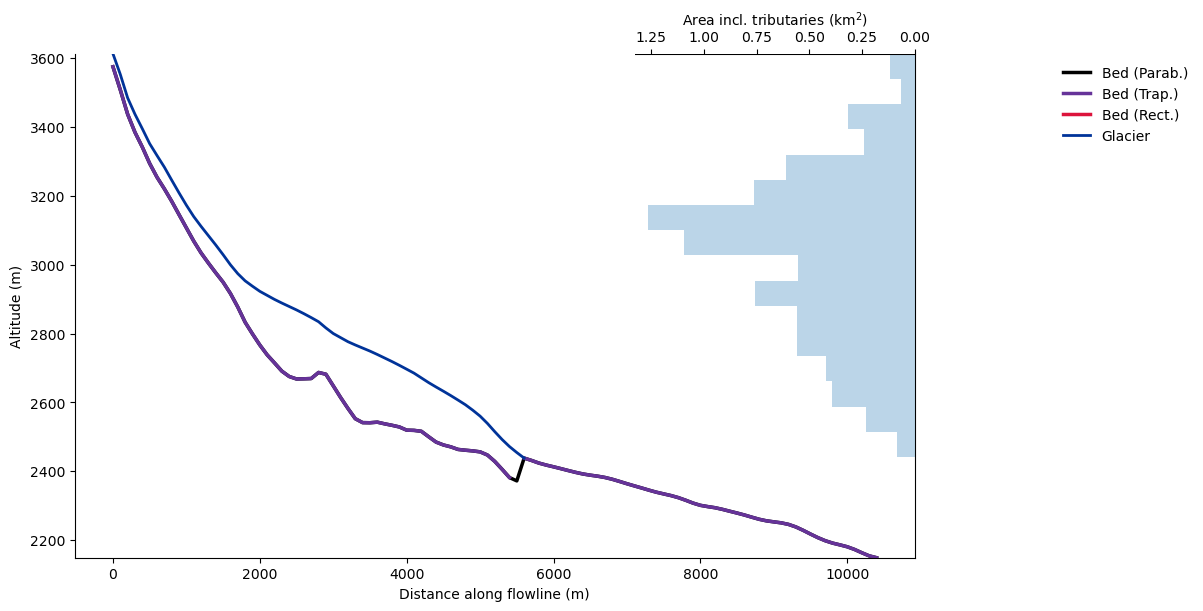

In [8]:
fls_no_filter_no_calibration = gdir.read_pickle('model_flowlines', filesuffix='_no_filter_no_calibration')
graphics.plot_modeloutput_section(fls_no_filter_no_calibration)

<div class="alert alert-warning">
    <b>Task</b>: Why do we see a large overdeepening at the terminus? (Hint: Review how the inversion is performed in the documentation and think again about the equilibrium assumption.)
</div>

Your anwser here:

Since we are aware of the overdeepening problem, we can fix it by applying a filter at the terminus. Let’s redo the inversion with the filter applied and then check the difference:

In [9]:
# let's redo the inversion, by using a filter at the terminus
global_tasks.inversion_tasks(gdirs,
                             filter_inversion_output=True
                            )
workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs,
                             filesuffix='_no_calibration');

2025-04-28 09:25:08: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2025-04-28 09:25:08: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2025-04-28 09:25:08: oggm.core.inversion: (RGI60-11.00897) prepare_for_inversion
2025-04-28 09:25:08: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2025-04-28 09:25:08: oggm.core.inversion: (RGI60-11.00897) mass_conservation_inversion
2025-04-28 09:25:08: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2025-04-28 09:25:08: oggm.core.inversion: (RGI60-11.00897) filter_inversion_output
2025-04-28 09:25:08: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2025-04-28 09:25:08: oggm.core.flowline: (RGI60-11.00897) init_present_time_glacier_no_calibration


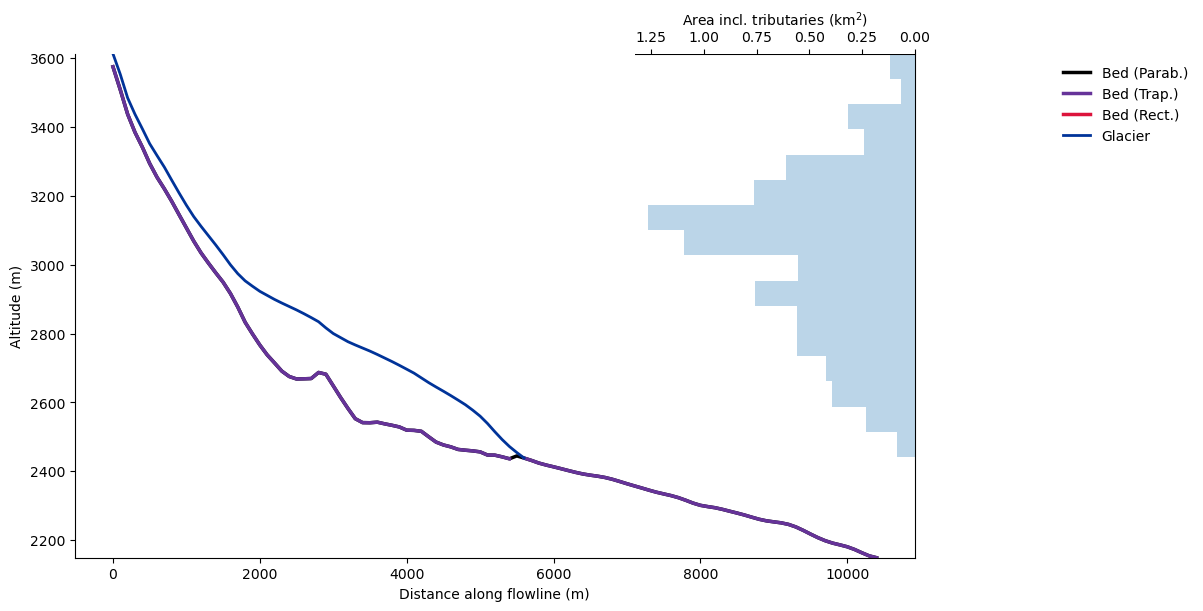

In [10]:
fls_no_calibration = gdir.read_pickle('model_flowlines', filesuffix='_no_calibration')
graphics.plot_modeloutput_section(fls_no_calibration)

After completing the inversion, we can take a look at our calculated volume and compare it to another volume estimate, specifically, the consensus estimate from [Farinotti et al. (2019)](https://doi.org/10.1038/s41561-019-0300-3).

In [11]:
# Define a function to compare the modelled volume with the consensus estimate
def print_modelled_and_estimated_volume(gdir):
    # Get the modelled volume from the bed inversion (convert from m³ to km³)
    model_volume = tasks.get_inversion_volume(gdir) * 1e-9  # km³

    # Get the consensus estimate volume (convert from m³ to km³)
    estimated_volume = pd.read_hdf(utils.get_demo_file('rgi62_itmix_df.h5')).loc[gdir.rgi_id]['vol_itmix_m3'] * 1e-9  # km³
    
    print(f"Estimated volume: {estimated_volume:.3f} km³")
    print(f'Modelled volume: {model_volume:.3f} km³')

print_modelled_and_estimated_volume(gdir)

2025-04-28 09:25:08: oggm.core.inversion: (RGI60-11.00897) get_inversion_volume


Estimated volume: 0.578 km³
Modelled volume: 0.726 km³


As you can see, we are quite far off. The reason for this is that we used the default Glen A parameter during the inversion:

In [12]:
gdir.get_diagnostics()['inversion_glen_a']

2.4e-24

You can redo the inversion using your own Glen A parameter by setting the glen_a keyword argument.

Can you find a better match to the estimated volume?

In [13]:
# let's redo the inversion, by using a filter at the terminus
global_tasks.inversion_tasks(gdirs,
                             filter_inversion_output=True,
                             # here you can play around by providing your own Glen A paramter
                             glen_a=gdir.get_diagnostics()['inversion_glen_a'] * 1,
                            )
workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs,
                             filesuffix='_your_glen_a');

2025-04-28 09:25:08: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2025-04-28 09:25:08: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2025-04-28 09:25:08: oggm.core.inversion: (RGI60-11.00897) prepare_for_inversion
2025-04-28 09:25:08: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2025-04-28 09:25:08: oggm.core.inversion: (RGI60-11.00897) mass_conservation_inversion
2025-04-28 09:25:08: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2025-04-28 09:25:08: oggm.core.inversion: (RGI60-11.00897) filter_inversion_output
2025-04-28 09:25:08: oggm.workflow: Execute entity tasks [init_present_time_glacier] on 1 glaciers
2025-04-28 09:25:08: oggm.core.flowline: (RGI60-11.00897) init_present_time_glacier_your_glen_a


<div class="alert alert-warning">
    <b>Task</b>: What does the Glen A parameter describe? In which direction do you think we need to change it to bring the modelled volume closer to the estimated one? (Hint: Take a look at the <a href="https://docs.oggm.org/en/stable/ice-dynamics.html#ice-flow">OGGM documentation</a> and the plot in <a href="https://tutorials.oggm.org/stable/notebooks/tutorials/inversion.html#sensitivity-analysis">this section of the OGGM tutorials</a>.)
</div>

Your answer here:

### Bed inversion with calibration to estimated volume

Fortunately, OGGM has a functionality that allows us to take the estimated volume into account and calibrate the Glen A parameter for better agreement:

In [14]:
# when we use all glaciers, no Glen A could be found within the range [0.1,10] that would match the consensus estimate
# usually, this is applied on larger regions where this error should not occur ! 
workflow.calibrate_inversion_from_consensus(gdirs, filter_inversion_output=True);
workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs);

2025-04-28 09:25:09: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2025-04-28 09:25:09: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2025-04-28 09:25:09: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2025-04-28 09:25:09: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2025-04-28 09:25:09: oggm.core.inversion: (RGI60-11.00897) prepare_for_inversion
2025-04-28 09:25:09: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2025-04-28 09:25:09: oggm.core.inversion: (RGI60-11.00897) mass_conservation_inversion
2025-04-28 09:25:09: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2025-04-28 09:25:09: oggm.core.inversion: (RGI60-11.00897) filter_inversion_output
2025-04-28 09:25:09: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2025-04-28 09:25:09: oggm.core.inversion: (RGI60-11.00897) get_inversion

In the default OGGM workflow, this calibration is not done for each glacier individually, but rather for an entire region.
The reason is that the consensus volume estimate is still just an estimate, not a direct observation. We assume larger errors for individual glaciers, but that the estimate becomes more accurate when averaged over large regions.

Now, let’s check again how well we match the estimated volume:

In [15]:
print_modelled_and_estimated_volume(gdir)

2025-04-28 09:25:09: oggm.core.inversion: (RGI60-11.00897) get_inversion_volume


Estimated volume: 0.578 km³
Modelled volume: 0.578 km³


Great, now we have a perfect match!

Let’s take a look at the Glen A parameter that was used. Did it change in the direction you expected?

In [16]:
gdir.get_diagnostics()['inversion_glen_a']

8.61183720486046e-24

Finally, let’s plot the three glacier beds we created today side by side (if you want you can also add your own bed inversion here):

Text(0.0, 1.0, '  OGGM default')

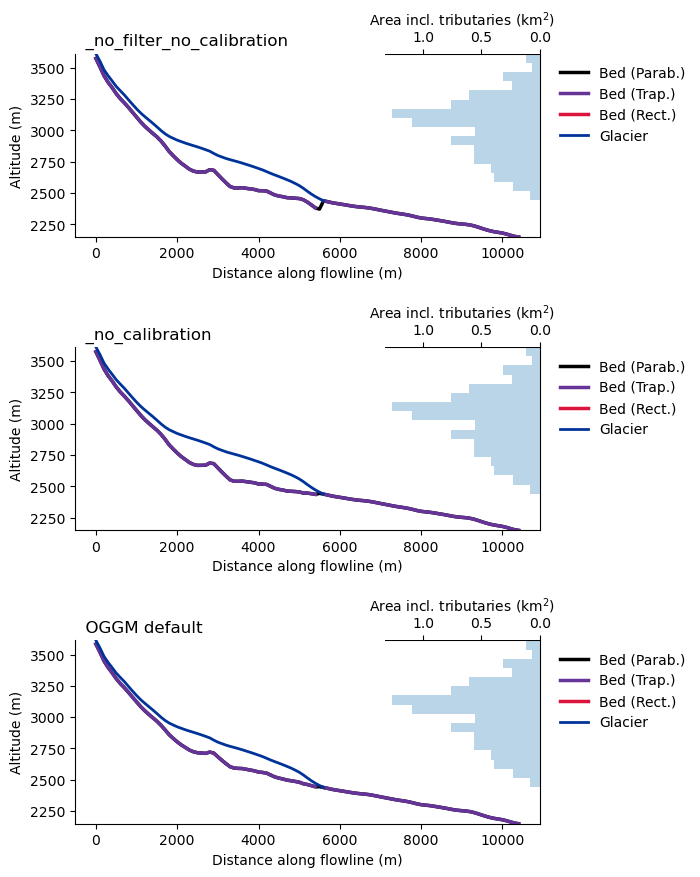

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(6,10), gridspec_kw={'hspace': 0.6})

# our intial approach, without a filter at the terminus and no calibration
graphics.plot_modeloutput_section(fls_no_filter_no_calibration, ax=axs[0])
axs[0].set_title('  _no_filter_no_calibration', loc='left')

# our secend try, with a filter at the terminus, but no calibration
graphics.plot_modeloutput_section(fls_no_calibration, ax=axs[1])
axs[1].set_title('  _no_calibration', loc='left')

# our final bed inversion, with a filter and with a calibration
fls_oggm = gdir.read_pickle('model_flowlines')
graphics.plot_modeloutput_section(fls_oggm, ax=axs[2])
axs[2].set_title('  OGGM default', loc='left')

<div class="alert alert-warning">
    <b>Task</b>: Summarize the differences between the three glacier geometries in your own words.
</div>

Your answer here:

<div class="alert alert-warning">
    <b>Bonus-task</b>: Calculate the differences between the flowline thicknesses of the different glacier beds and compare them.
</div>

In [18]:
# Hint you can get access to the thickness with the following code
fls_oggm[0].thick

array([ 29.28945566,  34.62663341,  36.53755592,  40.58641775,
        41.25818456,  44.49791086,  48.75648043,  48.71668893,
        47.52216502,  48.87492819,  50.99040376,  55.14222366,
        59.63352759,  61.57725439,  62.53758894,  61.73621012,
        64.52398491,  74.97981723,  92.79402728, 106.80211837,
       119.97007016, 132.65136177, 141.29734588, 151.19945974,
       155.2196681 , 153.00266311, 144.62906195, 135.67074525,
       113.29623501, 103.49413621, 116.70473159, 133.09838261,
       147.65260182, 162.69938521, 164.55436763, 158.23036129,
       149.7322795 , 145.70758511, 141.22764002, 136.57570437,
       134.93440589, 126.71821725, 118.39253064, 119.96281391,
       122.05373962, 119.20176398, 113.86767212, 109.54830123,
       101.06617402,  90.60813407,  79.64750889,  70.42220597,
        52.73972897,  39.25530554,  27.88211289,   9.79911962,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.  

## Bonus: Distributed thickness

There are also some functionalities available to redistribute the flowline thickness back onto the grid:

In [19]:
# Distribute flowline thickness to the grid
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);

2025-04-28 09:25:09: oggm.workflow: Execute entity tasks [distribute_thickness_per_altitude] on 1 glaciers
2025-04-28 09:25:09: oggm.core.inversion: (RGI60-11.00897) distribute_thickness_per_altitude
2025-04-28 09:25:09: oggm.core.gis: (RGI60-11.00897) gridded_attributes


Before we look at the results, let's also add some observations for comparison, starting with the consensus estimate from [Farinotti et al. (2019)](https://doi.org/10.1038/s41561-019-0300-3).

In [20]:
from oggm.shop import bedtopo
workflow.execute_entity_task(bedtopo.add_consensus_thickness, gdirs);

2025-04-28 09:25:09: oggm.workflow: Execute entity tasks [add_consensus_thickness] on 1 glaciers
2025-04-28 09:25:09: oggm.shop.bedtopo: (RGI60-11.00897) add_consensus_thickness


And now, let's add a velocity-based estimate from [Millan et al. (2022)](https://doi.org/10.1038/s41561-021-00885-z):

In [21]:
from oggm.shop import millan22
workflow.execute_entity_task(millan22.thickness_to_gdir, gdirs);

2025-04-28 09:25:10: oggm.workflow: Execute entity tasks [thickness_to_gdir] on 1 glaciers
2025-04-28 09:25:10: oggm.shop.millan22: (RGI60-11.00897) thickness_to_gdir


Okay, let’s load the data and compare it in a plot:

In [22]:
# load all gridded data, this is the grid we defined in the second session
with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
    ds = ds.load()

Text(0.5, 1.0, 'Millan et al. (2022)')

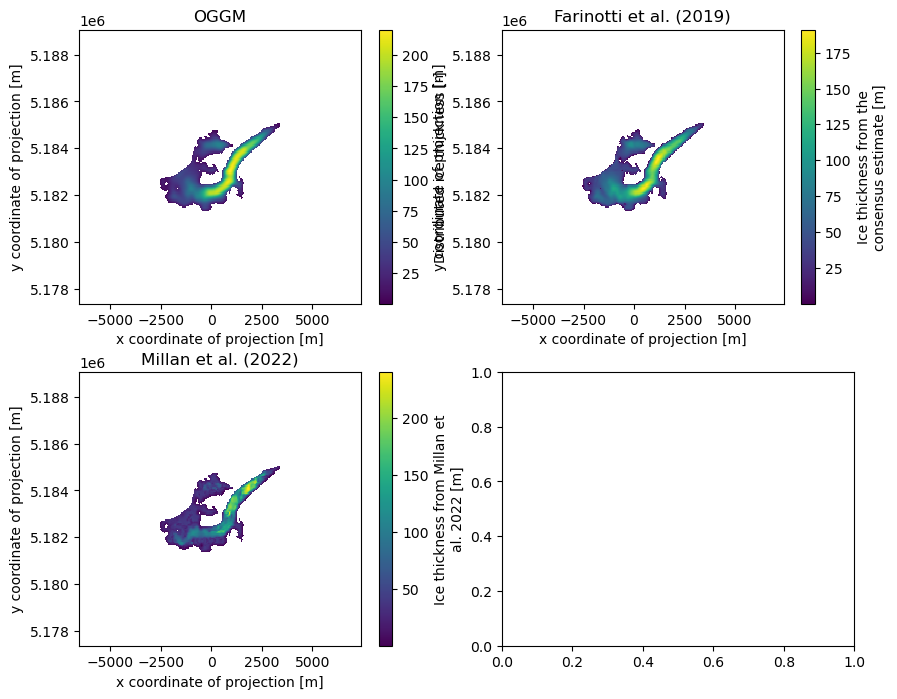

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(10,8), gridspec_kw={'hspace': 0.25})

# the oggm output
ax_oggm = axs[0, 0]
ds.distributed_thickness.plot(ax=ax_oggm);
ax_oggm.set_title('OGGM')

# the consensus estimate
ax_consensus = axs[0, 1]
ds.consensus_ice_thickness.plot(ax=ax_consensus)
ax_consensus.set_title('Farinotti et al. (2019)')

# the Millan estimate
ax_millan = axs[1, 0]
ds.where(ds.glacier_mask).millan_ice_thickness.plot(ax=ax_millan)
ax_millan.set_title('Millan et al. (2022)')


<div class="alert alert-warning">
    <b>Task</b>: What differences do you notice?
</div>

Your answer here:

## Recap

- We need to assume equilibrium during the inversion process.
- This assumption can lead to overdeepenings at the terminus for retreating glaciers.
- We can use a total volume estimate to calibrate the glacier flow parameter Glen A.